# Analysis of Customer Loans Data 

In [1]:
from transformations import Analysis, Plotter, DataTransform
import pandas as pd

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

I used a copy of the loan payments dataset after addressing null values but before applying any skew correction. Since my analysis requires actual  figures of money, applying skew correction would distort the actual amounts.

In [2]:
loans_df = pd.read_csv('loan_payments_no_null.csv')

pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True 

analysis = Analysis()
plot = Plotter()
transform = DataTransform()

def date_format(dataframe, *args):
    for col in args:
        dataframe[col] = pd.to_datetime(dataframe[col], errors='coerce')
    return(dataframe)

loans_df = date_format(loans_df,'issue_date', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date')
transform.convert_employment_back(loans_df)

loans_df.head()
#loans_df['employment_length'].info()

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,employment_length,home_ownership,annual_inc,verification_status,issue_date,loan_status,payment_plan,purpose,dti,delinq_2yrs,earliest_credit_line,inq_last_6mths,open_accounts,total_accounts,out_prncp,out_prncp_inv,total_payment,total_payment_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,5 years,MORTGAGE,46000.0,Not Verified,2021-01-01,Current,n,credit_card,19.54,2,1987-10-01,1,12,27,5529.70,5529.70,2982.51,2982.51,2470.30,512.21,0.0,0.0,0.0,2022-01-01,248.82,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,9 years,RENT,50000.0,Not Verified,2021-01-01,Current,n,credit_card,24.20,0,2001-09-01,0,15,31,9102.83,9102.83,4885.11,4885.11,4097.17,787.94,0.0,0.0,0.0,2022-01-01,407.52,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,8 years,MORTGAGE,73913.0,Source Verified,2021-01-01,Fully Paid,n,credit_card,16.92,0,1998-09-01,0,7,18,0.00,0.00,16824.54,16824.54,16000.00,824.54,0.0,0.0,0.0,2021-10-01,12850.16,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,1 year,RENT,42000.0,Source Verified,2021-01-01,Fully Paid,n,debt_consolidation,35.52,0,2008-06-01,0,6,13,0.00,0.00,15947.47,15947.47,15000.00,947.47,0.0,0.0,0.0,2021-06-01,13899.67,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,10+ years,MORTGAGE,145000.0,Verified,2021-01-01,Current,n,debt_consolidation,3.33,0,2002-04-01,1,23,50,10297.47,10297.47,5473.46,5473.46,4702.53,770.93,0.0,0.0,0.0,2022-01-01,456.54,2022-01-01,0.0,1,INDIVIDUAL


**Summarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.**

**Additionally calculate how much will be paid back in 6 months time with interest. Visualise your results on an appropriate graph.**


Percentage of loans currently recovered compared to the total amount to be paid over the loans term: 70.68
Total amount that will be paid in 6 months time: 130014398.76


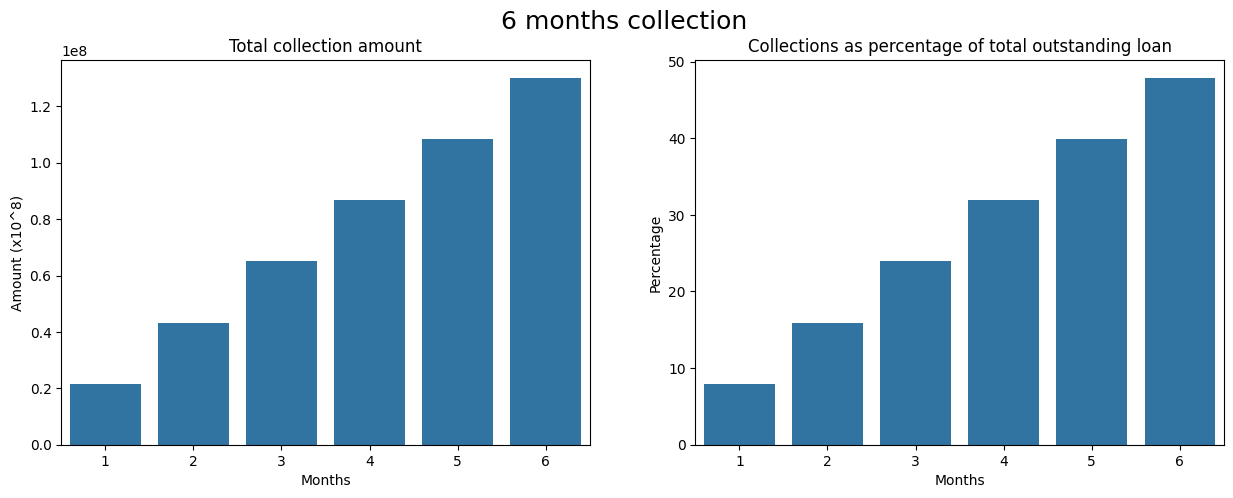

In [3]:
#Find total loan that needs to be paid 
loans_df['total_to_be_paid'] = loans_df['instalment']*loans_df['term']

#Find percenatage of what has been paid 
loan_percentage = round(loans_df['total_payment'].sum()/loans_df['total_to_be_paid'].sum()*100, 2)
print(f'Percentage of loans currently recovered compared to the total amount to be paid over the loans term: {loan_percentage}') 

#Find values for barcharts and create labels to visulise collection in 6 months   
months = [1, 2, 3, 4, 5, 6]
x_label='Months'

y_values_1 = analysis.monthly_instalment_amount(loans_df, 6)
print(f'Total amount that will be paid in 6 months time: {y_values_1[-1]}')  #Print total amount paid in 6 months time 

y_label_1 = 'Amount (x10^8)'
title_1 = 'Total collection amount'

y_values_2 = analysis.monthly_instalment_percentage_outstanding(loans_df, 6)
y_label_2 = 'Percentage'
title_2 = 'Collections as percentage of total outstanding loan'
plot_title = '6 months collection'

plot.plot_two_barplots(months, y_values_1,x_label,y_label_1, title_1,months, y_values_2, x_label, y_label_2, title_2 , plot_title)



**Loans marked as Charged Off in the loan_status column represent a loss to the company.**

**Calculate the percentage of charged off loans and the total amount that was paid towards these loans before being charged off.**

Percentage of charged off loans: 10.93%
Total amount paid towards charged off loans: 39649074.81


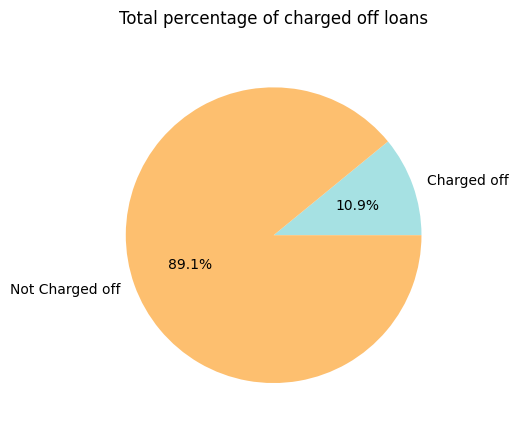

In [4]:
# Filter df to only include charged off loan status
charged_off_mask = (loans_df['loan_status'].str.contains('charged off', case=False) | loans_df['loan_status'].str.contains('default', case=False))
charged_off_df = loans_df[charged_off_mask].copy()

#Find percentage of charged off loans
percent_charged_off = round(len(charged_off_df)/len(loans_df)*100, 2)
print(f'Percentage of charged off loans: {percent_charged_off}%')

#Find total amount paid towards charged off loans
print(f'Total amount paid towards charged off loans: {round(charged_off_df['total_payment'].sum(), 2)}')

charged_off_percent = [percent_charged_off, 100-percent_charged_off]
charged_off_lables = ["Charged off", "Not Charged off"]

plot.pie_chart(charged_off_percent, charged_off_lables, 'Total percentage of charged off loans')

**Calculate the expected loss of the loans marked as Charged Off.**

Total value for all charged off loans: 106710968.88000001 
Expected loss in revenue for charged off loans (unpaid amount): 62072877.08


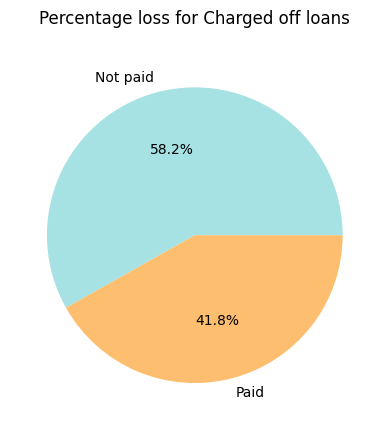

In [5]:
charged_off_df['total_to_be_paid'] = charged_off_df['instalment']*charged_off_df['term']
expexcted_loss = round(charged_off_df['total_to_be_paid'].sum() - (charged_off_df['total_payment'] + charged_off_df['recoveries']).sum(),2)
expexcted_loss_perccentage = round(expexcted_loss/charged_off_df['total_to_be_paid'].sum()*100, 2)

print(f'Total value for all charged off loans: {charged_off_df['total_to_be_paid'].sum()} \nExpected loss in revenue for charged off loans (unpaid amount): {expexcted_loss}')

loss_values = [expexcted_loss_perccentage, 100-expexcted_loss_perccentage]
loss_labels = ['Not paid', 'Paid']

plot.pie_chart(loss_values, loss_labels, 'Percentage loss for Charged off loans')

**Calculate the loss in revenue these loans would have generated for the company if they had finished their term.**

**Visualise the loss projected over the remaining term of these loans.**

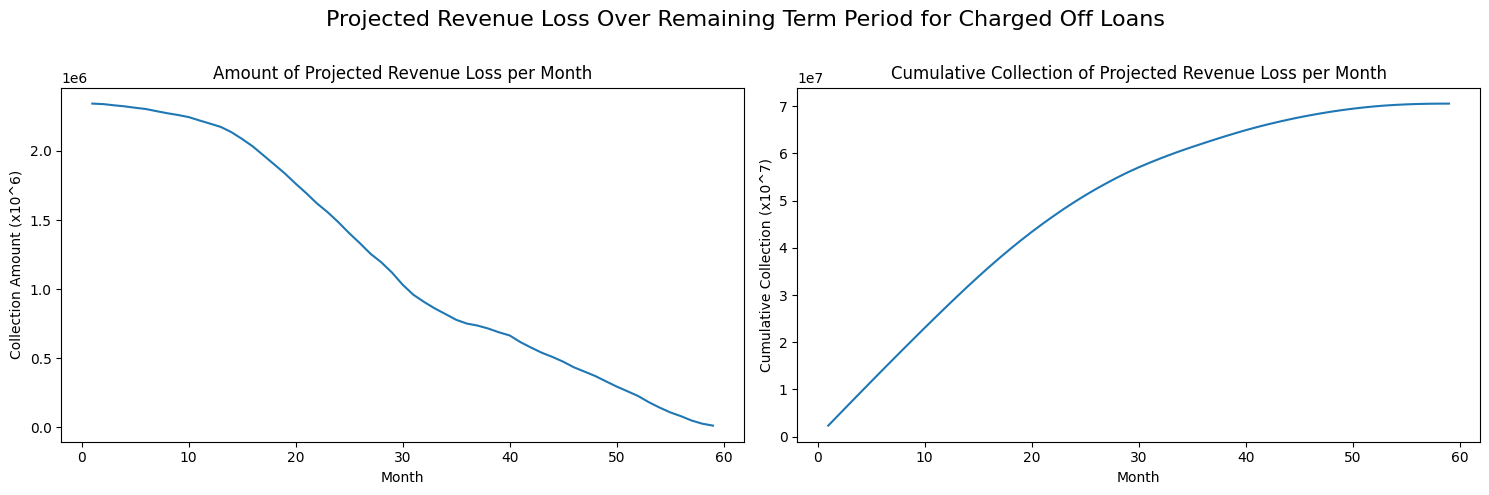

In [6]:
# Find how long of the term has passed 
charged_off_df['time_difference'] = (charged_off_df['last_payment_date'] - charged_off_df['issue_date'])
charged_off_df['day'] = pd.to_timedelta(charged_off_df['time_difference'], errors='coerce').dt.days
charged_off_df['day'] = charged_off_df['day'].astype('int64')

# Determine term number of months remaining 
charged_off_df['remaining_term'] = charged_off_df['term']-(round(charged_off_df['day']/30.4167))

positive_mask = (charged_off_df['remaining_term'] > 0)

charged_off_df_pos = charged_off_df[positive_mask]

# Determine the maximum remaining term among the loans
max_month = charged_off_df_pos['remaining_term'].max()

monthly_collections = []
for m in range(1, int(max_month) + 1):
    # For each month m, only include loans that have at least m months remaining.
    total_for_month = charged_off_df_pos.loc[charged_off_df_pos['remaining_term'] >= m, 'instalment'].sum()
    monthly_collections.append(total_for_month)

cumulative_collections = np.cumsum(monthly_collections)

line_xvalue = list(range(1, int(max_month) + 1))
line_xlabel = 'Month'

line_yvalue_1 = monthly_collections
line_ylabel_1 = 'Collection Amount (x10^6)'
line_title_1 = 'Amount of Projected Revenue Loss per Month'

line_yvalue_2 = cumulative_collections
line_ylabel_2 = 'Cumulative Collection (x10^7)'
line_title_2 = 'Cumulative Collection of Projected Revenue Loss per Month'

line_title = 'Projected Revenue Loss Over Remaining Term Period for Charged Off Loans'

plot.plot_two_line_graphs(line_xvalue,line_yvalue_1, line_xlabel, line_ylabel_1, line_title_1,line_xvalue, line_yvalue_2, line_xlabel, line_ylabel_2, line_title_2, line_title)

**There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.**

**What percentage do users in this bracket currently represent?**

In [7]:
late_loans_mask = ((loans_df['loan_status'].str.contains('late', case=False)) | (loans_df['payment_plan'] == 'y'))
late_loans_df = loans_df[late_loans_mask]

late_users_percentage = round(len(late_loans_df)/len(loans_df)*100, 2)
print(f'Percentage of users behind with their loan payments: {late_users_percentage}%')

Percentage of users behind with their loan payments: 1.27%


**Calculate the total amount of customers in this bracket and how much loss the company would incur if their status was changed to Charged Off.**

**What is the projected loss of these loans if the customer were to finish the full loan term?**



In [8]:
print(f'Total amount of customers with late loans: {len(late_loans_df)}')

late_immediate_loss = round(late_loans_df['out_prncp'].sum()+late_loans_df['recoveries'].sum(),2)
print(f'Immediate company loss if late loans were changed to charged off: {late_immediate_loss}')

late_loans_df['total_to_be_paid'] = late_loans_df['instalment']*late_loans_df['term']
late_projected_loss = round(late_loans_df['total_to_be_paid'].sum() - late_loans_df['total_payment'].sum(), 2)
print(f'Projected company loss if late loans were changed to charged off: {late_projected_loss}')


Total amount of customers with late loans: 687
Immediate company loss if late loans were changed to charged off: 6024730.62
Projected company loss if late loans were changed to charged off: 7315645.12


**If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?**

In [9]:
late_and_charged_off_revenue = late_loans_df['total_to_be_paid'].sum() + charged_off_df['total_to_be_paid'].sum()
print(f'Percentage of total expected revenue the charged off and late loans represent: {round(late_and_charged_off_revenue/loans_df['total_to_be_paid'].sum()*100,2)}%')

Percentage of total expected revenue the charged off and late loans represent: 13.05%


**Analyse the data to visualise the possible indicators that a customer will not be able to pay the loan.**

You will want to compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

Here are some example columns that might indicate that a user might not pay the loan:
- Does the grade of the loan have an effect on customers not paying?
- Is the purpose for the loan likely to have an effect?
- Does the home_ownership value contribute to the likelihood a customer won't pay?
- To help identify which columns will be of interest, first create a subset of these users.

Make the analysis and determine the columns are contributing to loans not being paid off and visualise any interesting indicators.

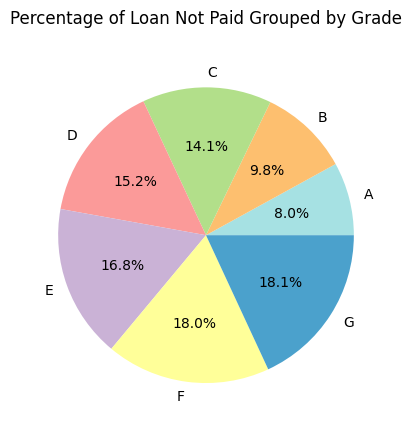

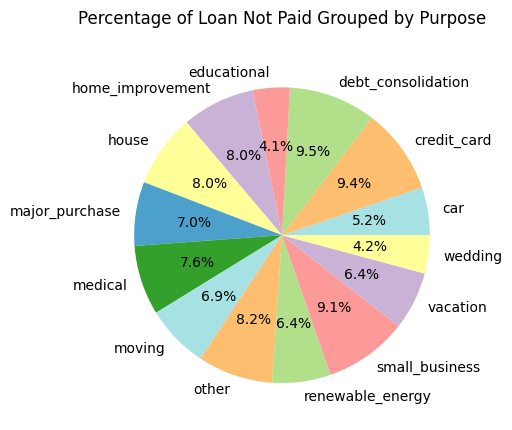

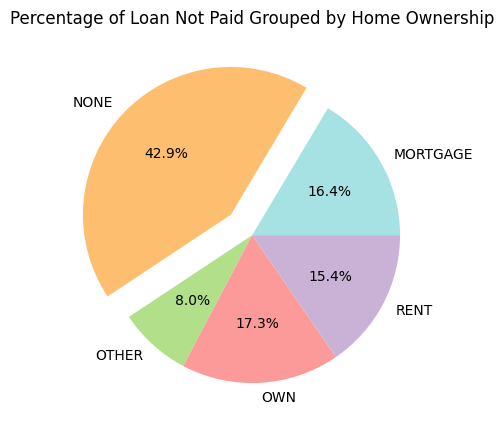

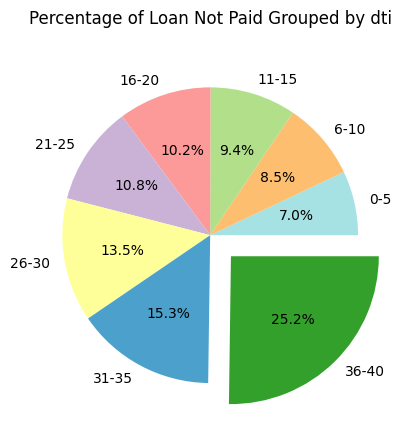

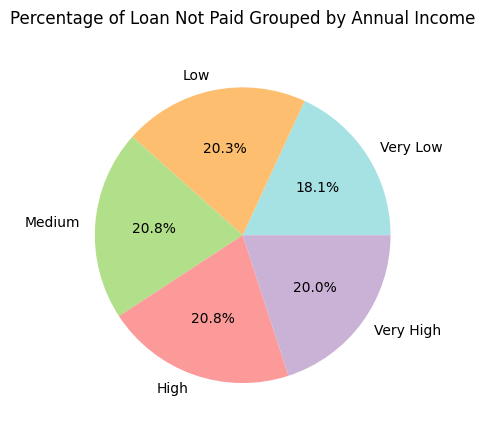

In [10]:
# Check if grade has effect on customers not paying
grade_summary = analysis.not_paid_percentage_by_group(loans_df, 'grade')
grade_chart_labels = list(grade_summary[1])
grade_chart_values = list(grade_summary[0])

plot.pie_chart(grade_chart_values, grade_chart_labels, 'Percentage of Loan Not Paid Grouped by Grade')

# Check if purpose has effect on customers not paying
purpose_summary = analysis.not_paid_percentage_by_group(loans_df, 'purpose')
purpose_chart_labels = list(purpose_summary[1])
purpose_chart_values = list(purpose_summary[0])

plot.pie_chart(purpose_chart_values, purpose_chart_labels, 'Percentage of Loan Not Paid Grouped by Purpose')

# Check if home ownership has effect on customers not paying
home_ownership_summary = analysis.not_paid_percentage_by_group(loans_df, 'home_ownership')
home_ownership_chart_labels = list(home_ownership_summary[1])
home_ownership_chart_values = list(home_ownership_summary[0])
home_ownership_explode = (0, 0.2, 0, 0, 0)

plot.pie_chart(home_ownership_chart_values, home_ownership_chart_labels, 'Percentage of Loan Not Paid Grouped by Home Ownership', home_ownership_explode)

# Check if dti has effect on customers not paying
dti_bins = np.arange(0, 41, 5)  # creates bins: [0, 5, 10, 15, 20, 25, 30, 35, 40]
dti_labels = ["0-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40"]

# Group the dti values into categories
loans_df['dti_group'] = pd.cut(loans_df['dti'], bins=dti_bins, labels=dti_labels, right=False)

dti_summary = analysis.not_paid_percentage_by_group(loans_df, 'dti_group')
dti_chart_labels = list(dti_summary[1])
dti_chart_values = list(dti_summary[0])
dti_explode = (0, 0, 0, 0, 0, 0, 0, 0.2)

plot.pie_chart(dti_chart_values, dti_chart_labels, 'Percentage of Loan Not Paid Grouped by dti', dti_explode)

# Check if annual income has effect on customers not paying
# Group the annual income values into categories
loans_df['annual_inc_group'] = pd.qcut(loans_df['annual_inc'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

annual_inc_summary = analysis.not_paid_percentage_by_group(loans_df, 'annual_inc_group')
annual_inc_chart_labels = list(annual_inc_summary[1])
annual_inc_chart_values = list(annual_inc_summary[0])

plot.pie_chart(annual_inc_chart_values, annual_inc_chart_labels, 'Percentage of Loan Not Paid Grouped by Annual Income')

**Compare these indicators between loans already charged off and loans that could change to charged off to check if these same factors apply to loans that have the potential to change to "Charged Off".**

Discrete Columns:
- 'term'
- 'grade'
- 'employment_length'
- 'home_ownership'
- 'purpose'

/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:569: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:570: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(paid_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:571: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,2].set_xticklabels(charged_default_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:572: UserWarning: set_ticklabels() should only be used with a

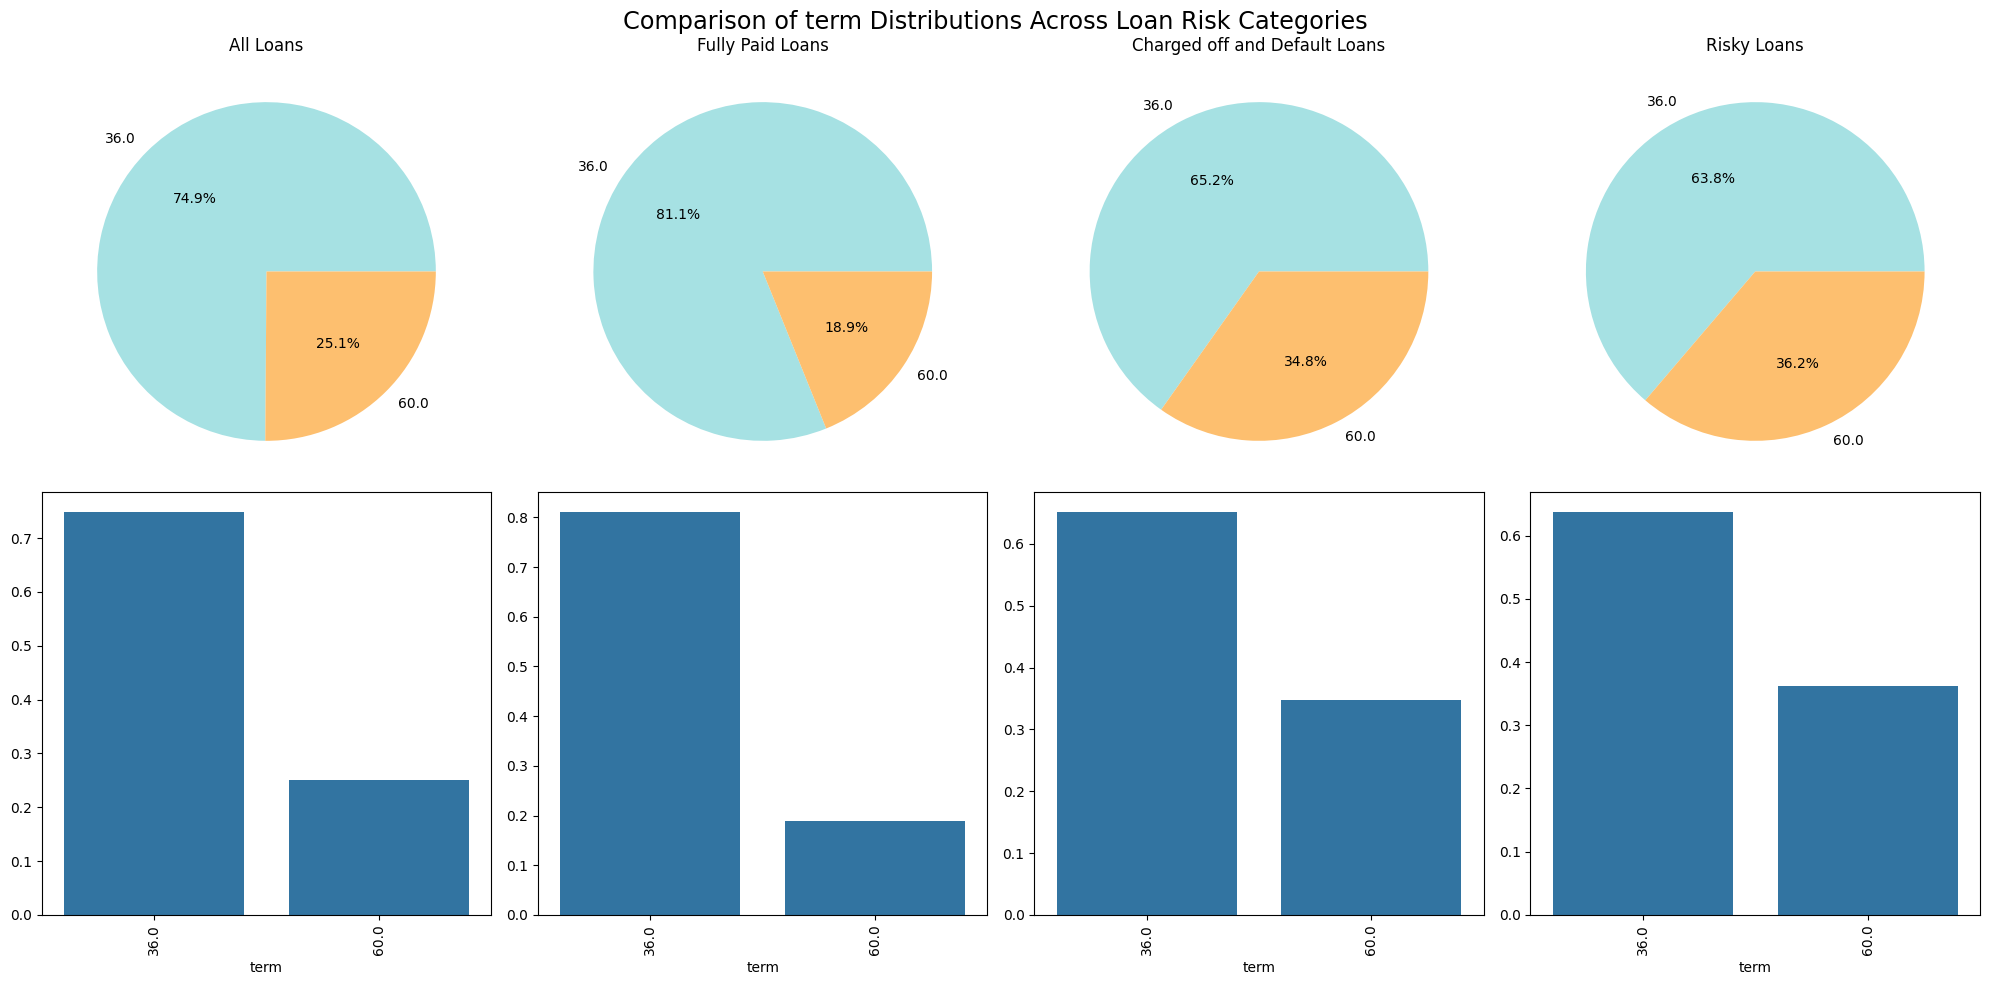

/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:569: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:570: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(paid_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:571: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,2].set_xticklabels(charged_default_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:572: UserWarning: set_ticklabels() should only be used with a

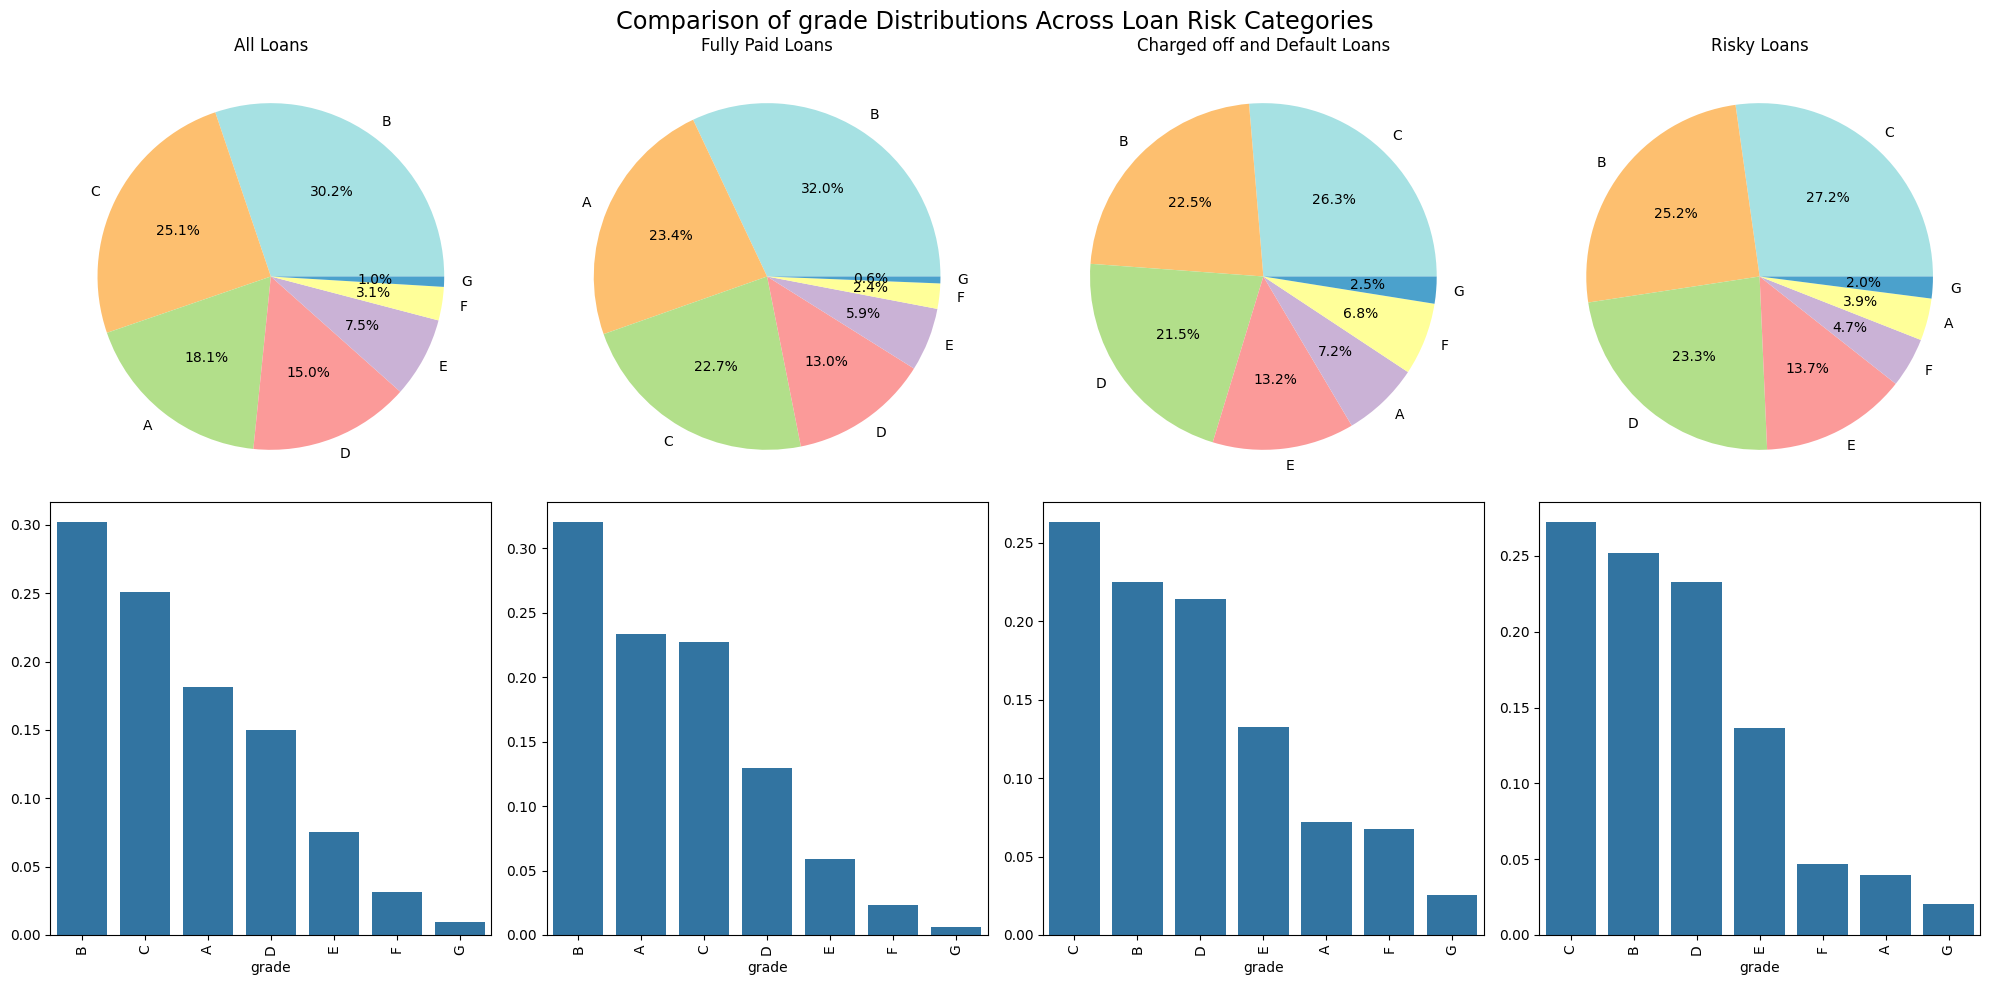

/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:569: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:570: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(paid_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:571: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,2].set_xticklabels(charged_default_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:572: UserWarning: set_ticklabels() should only be used with a

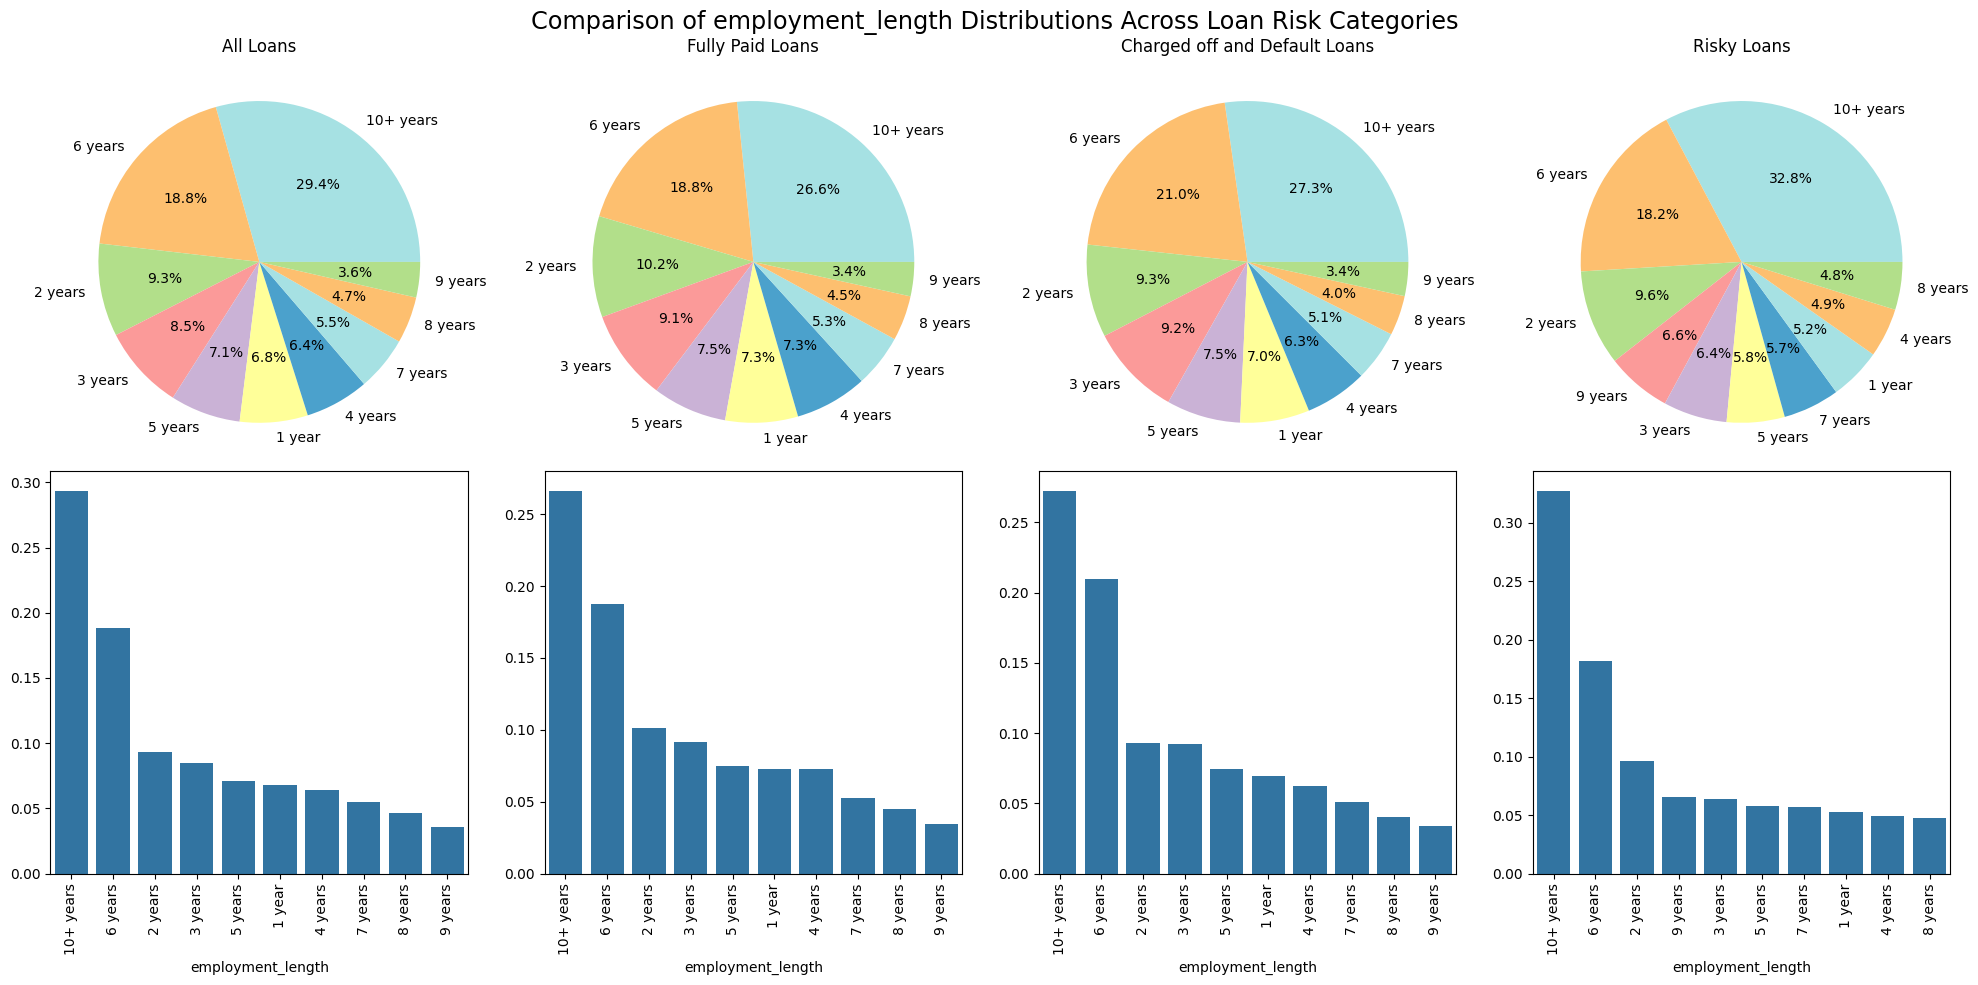

/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:569: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:570: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(paid_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:571: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,2].set_xticklabels(charged_default_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:572: UserWarning: set_ticklabels() should only be used with a

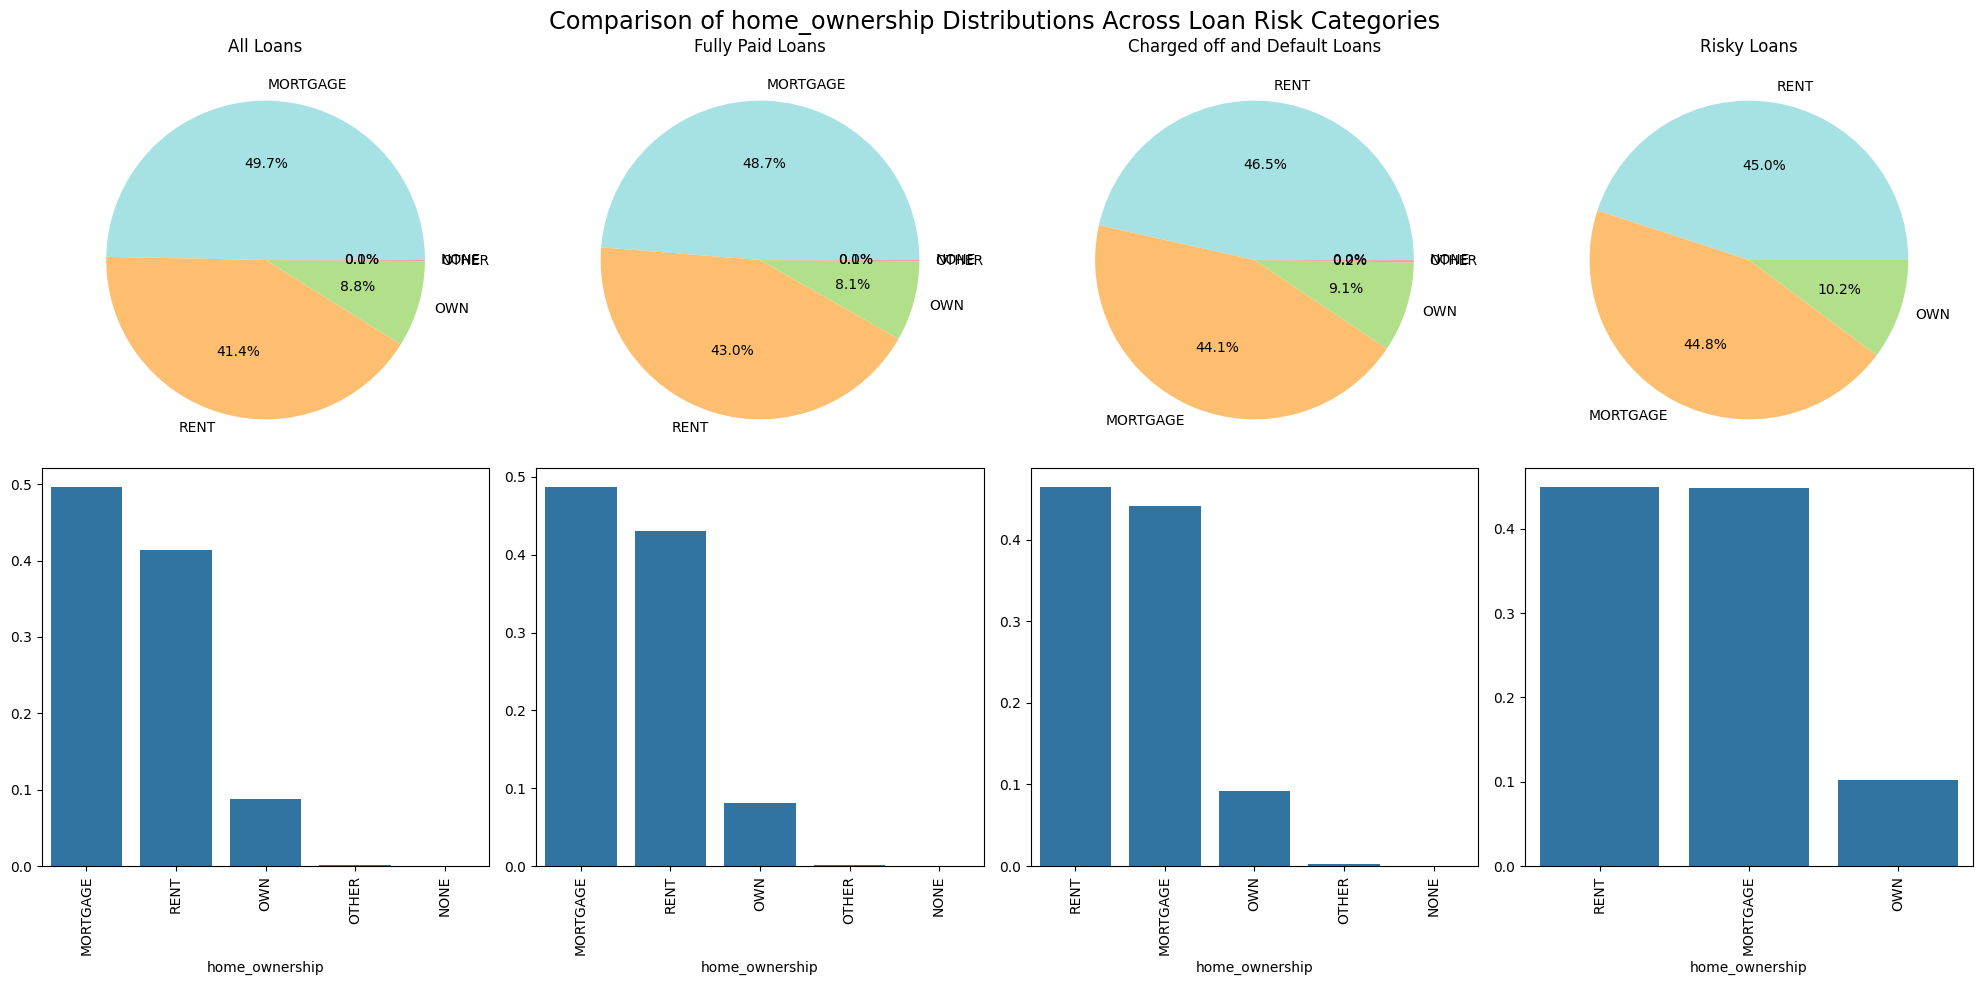

/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:569: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:570: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xticklabels(paid_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:571: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,2].set_xticklabels(charged_default_probabilities.index, rotation=90)
/Users/hosnashams/Desktop/AI-Core/eda-project/EDA-Customer-Loans/transformations.py:572: UserWarning: set_ticklabels() should only be used with a

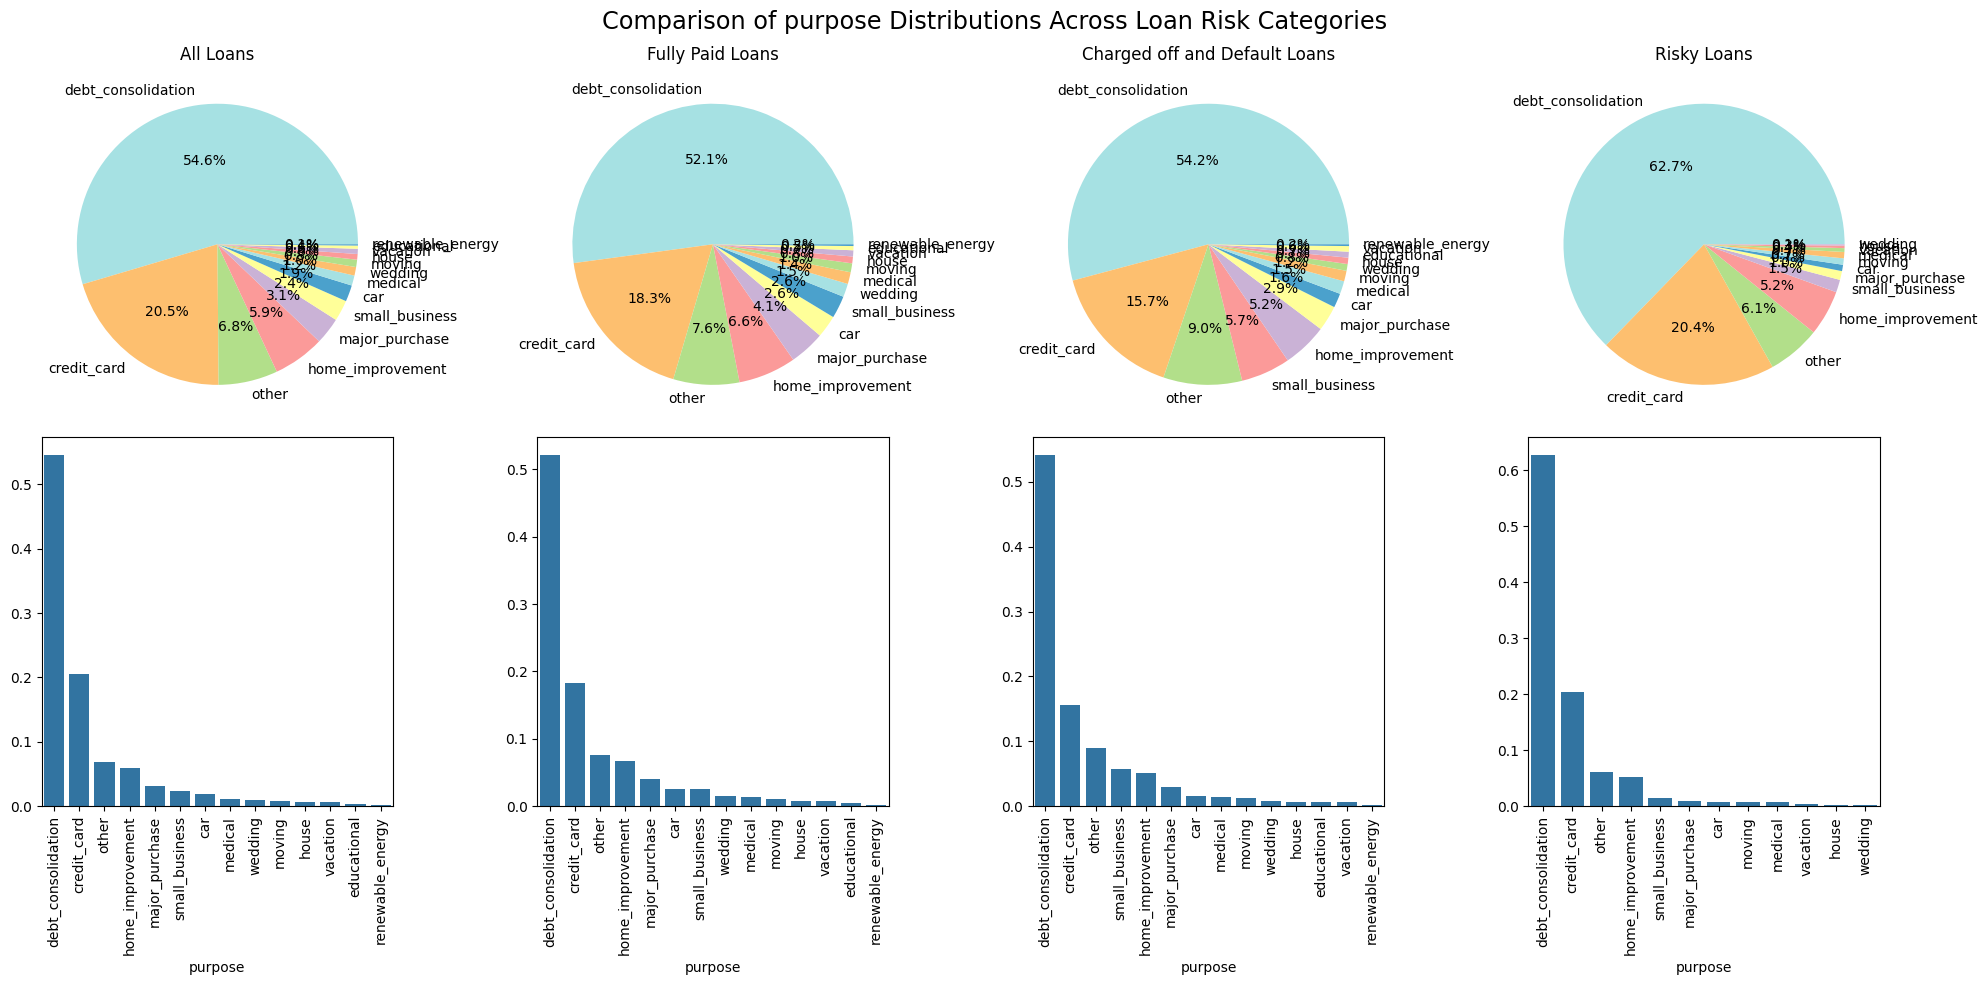

In [11]:
plot.discrete_value_risk_comparison(loans_df, 'term')
plot.discrete_value_risk_comparison(loans_df, 'grade')
plot.discrete_value_risk_comparison(loans_df, 'employment_length')
plot.discrete_value_risk_comparison(loans_df, 'home_ownership')
plot.discrete_value_risk_comparison(loans_df, 'purpose')

Continuous Columns:
- 'loan_amount'
- 'int_rate'
- 'instalment'
- 'annual_inc'
- 'open_accounts'
- 'dti'

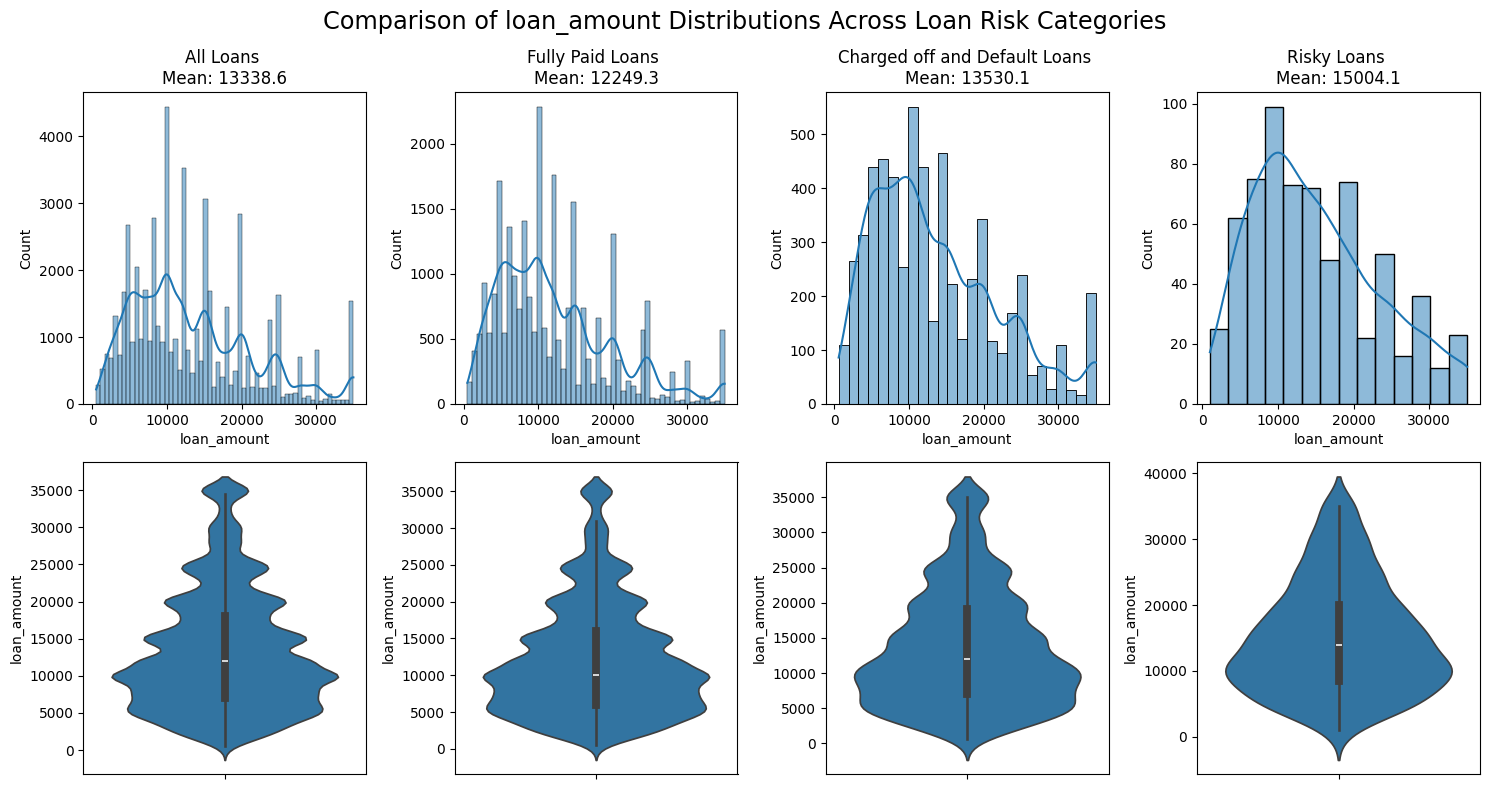

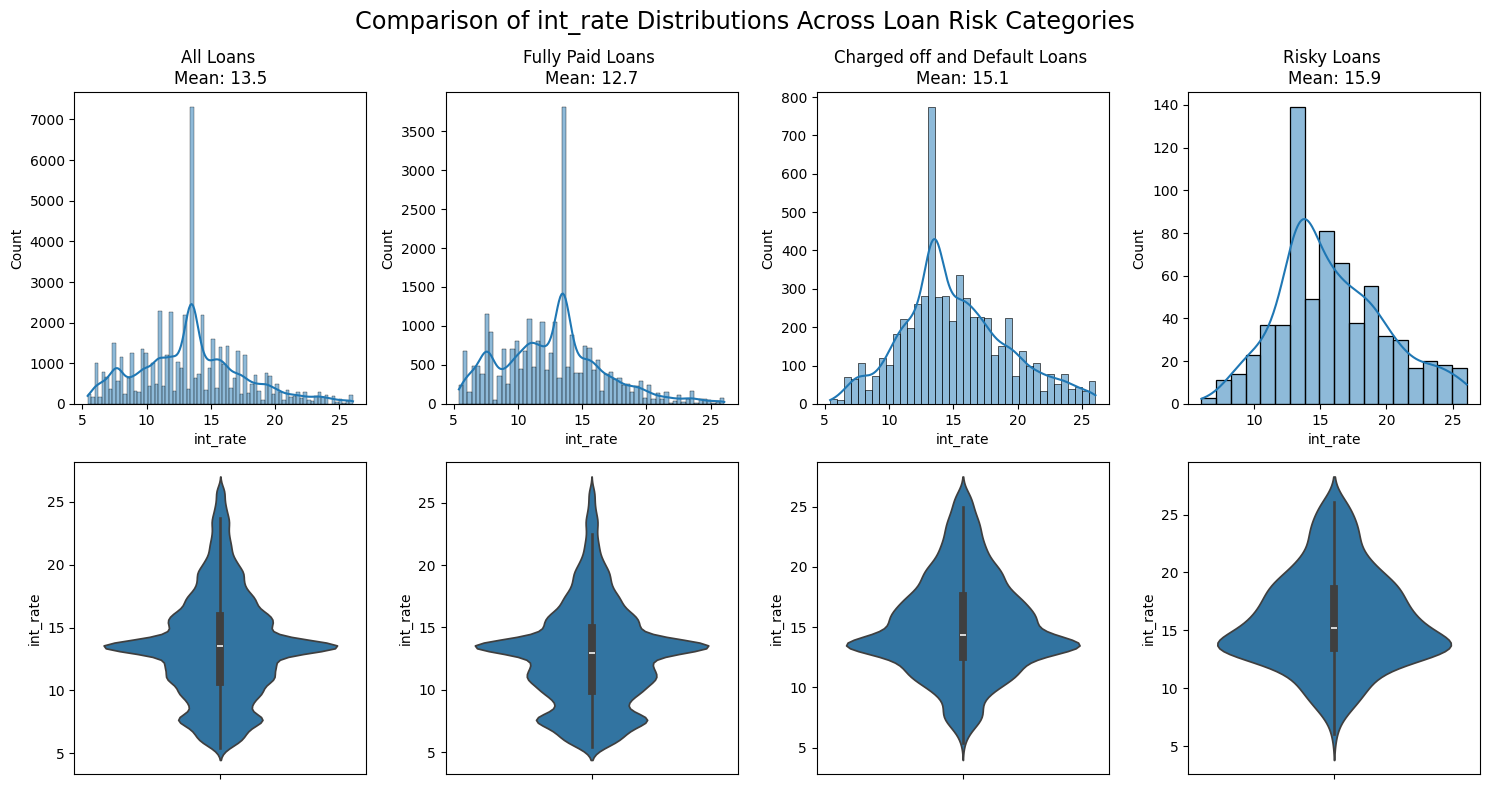

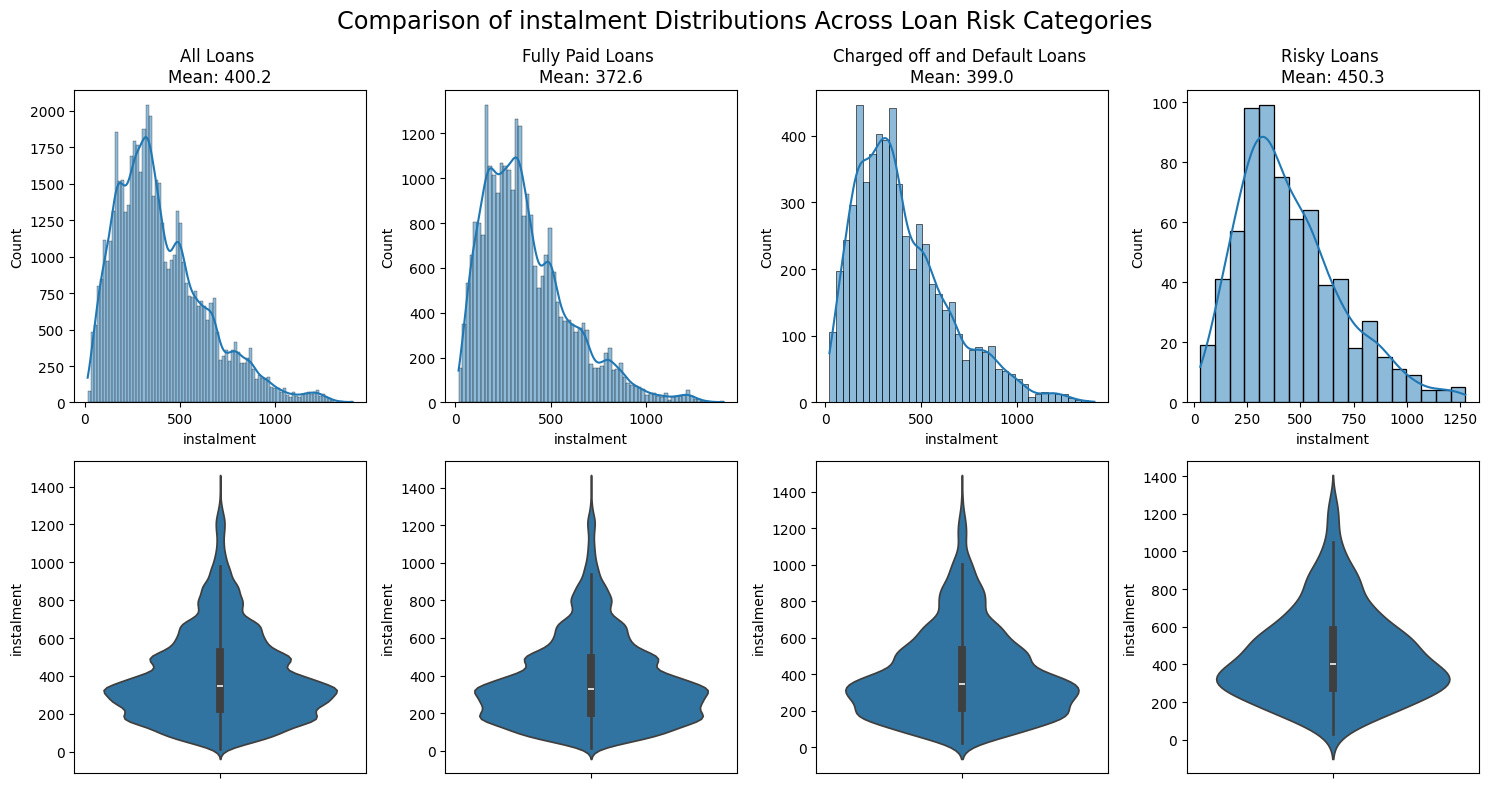

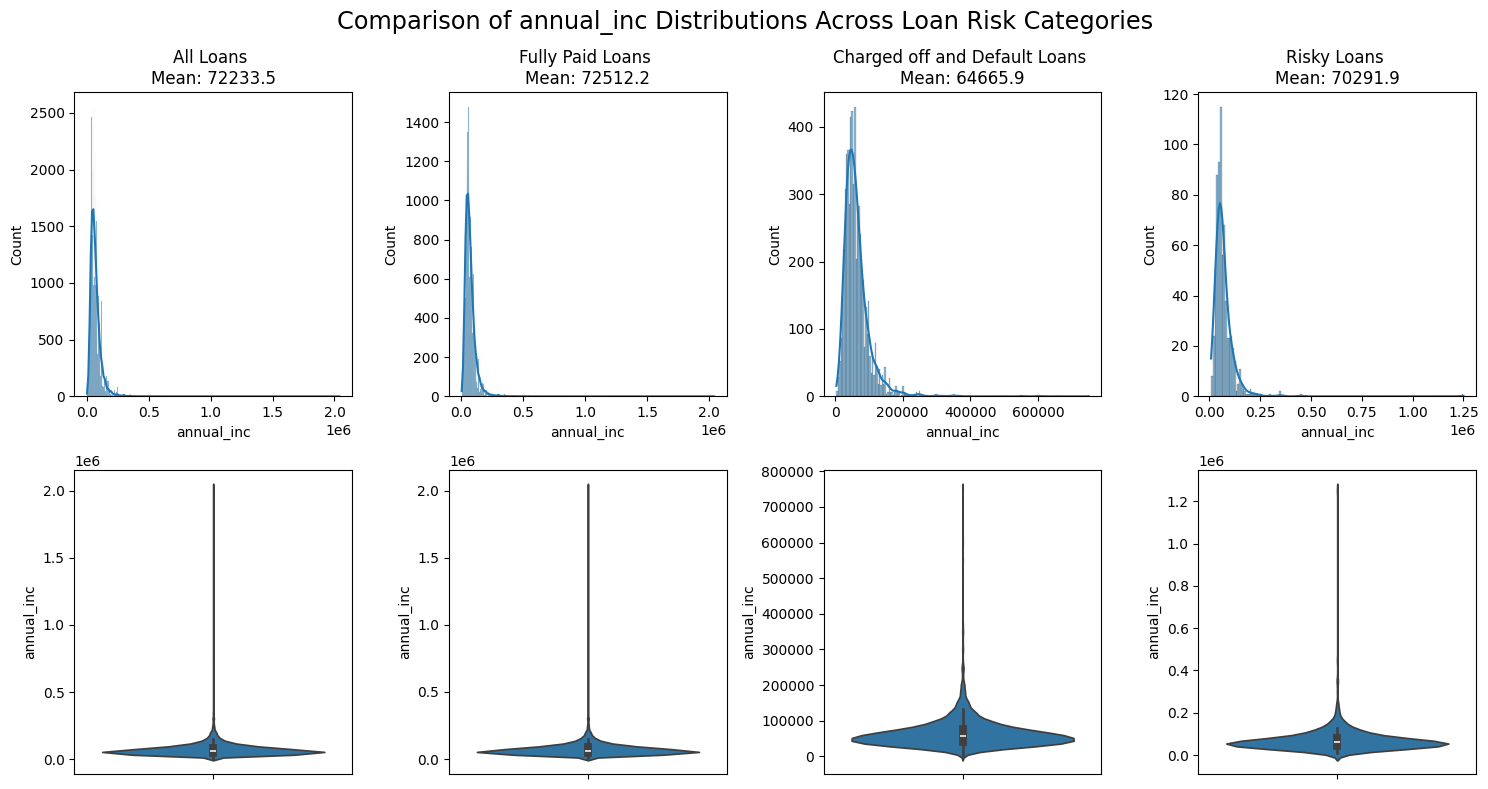

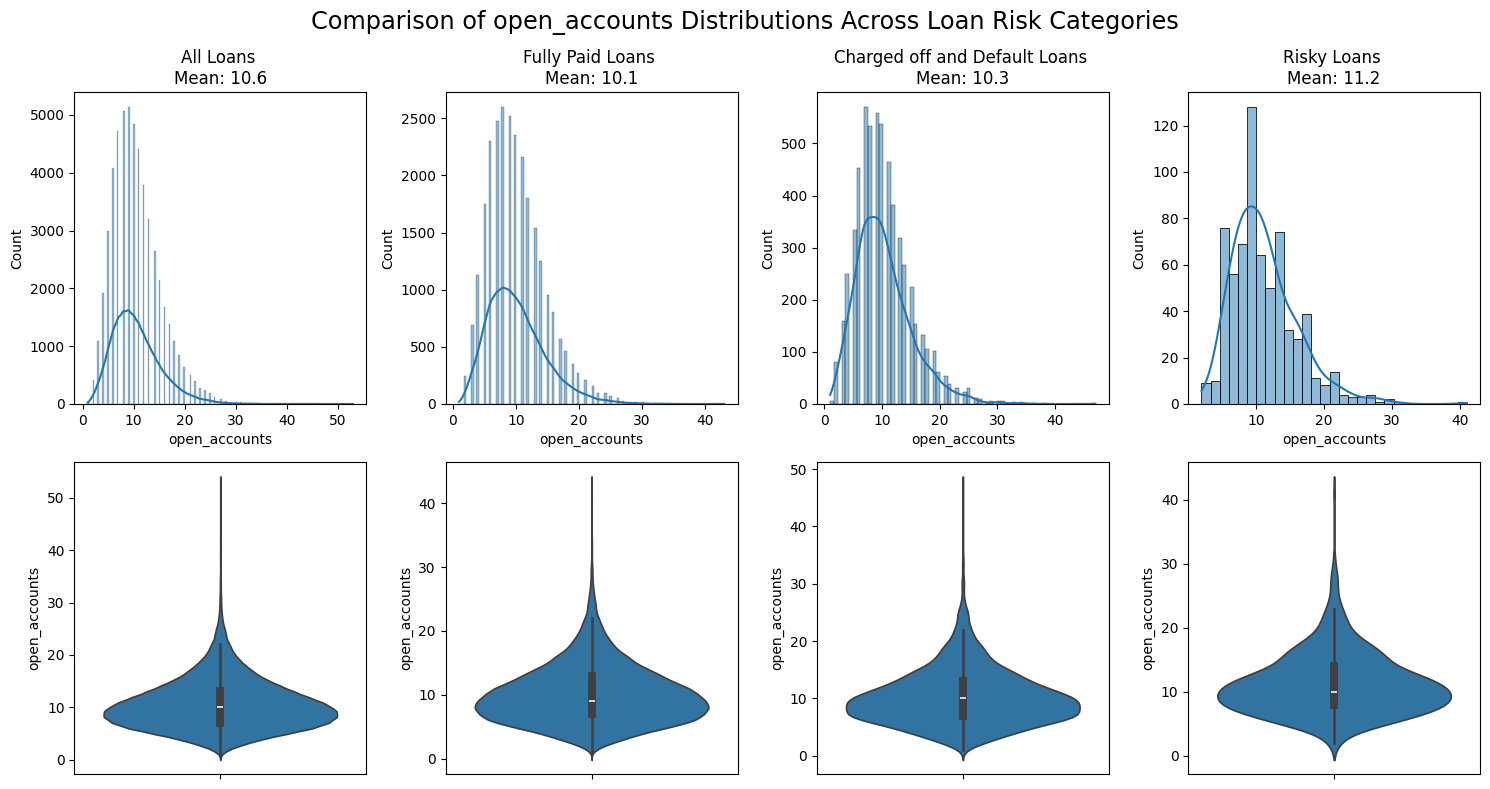

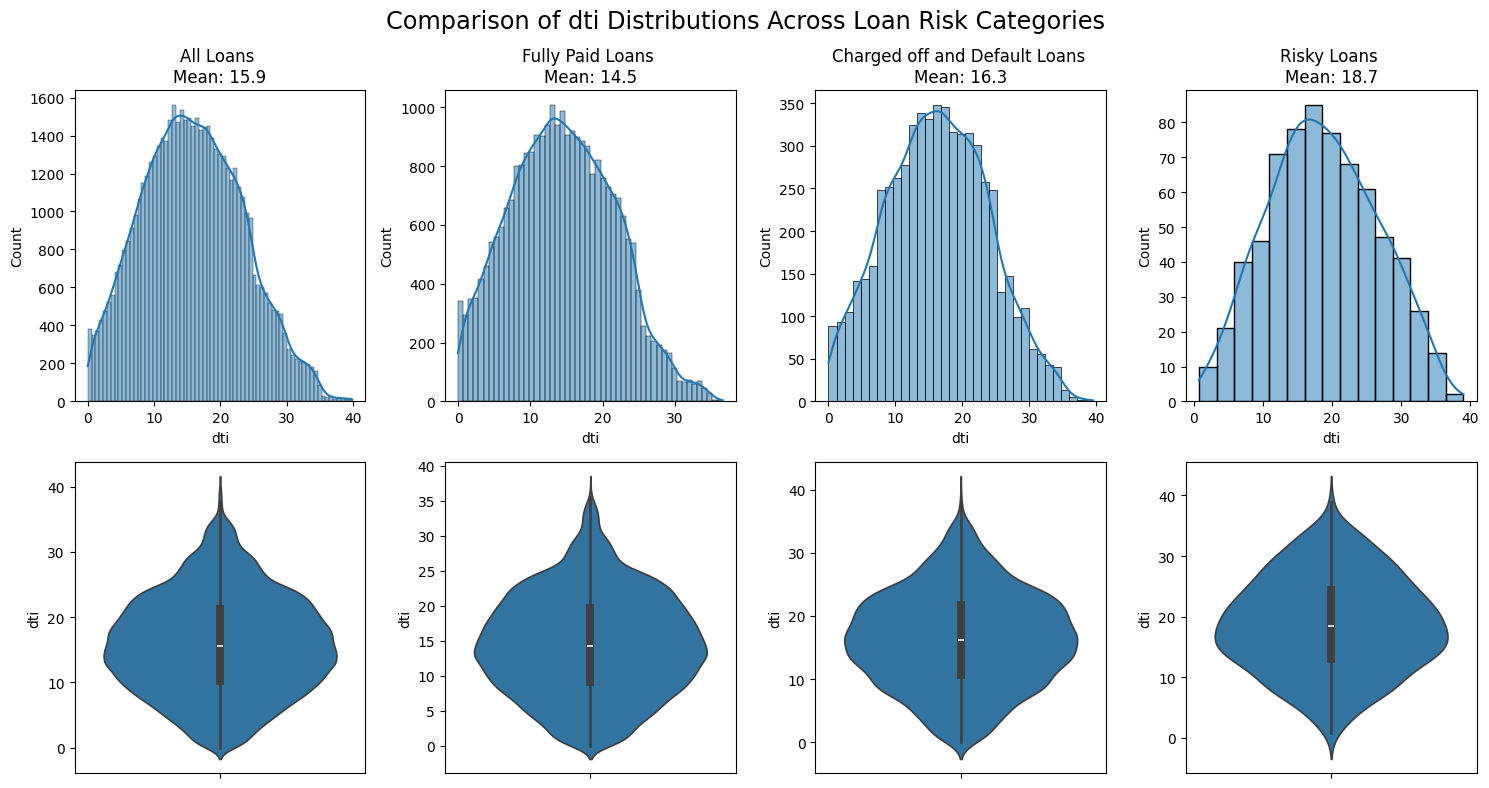

In [12]:
plot.continuous_value_risk_comparison(loans_df, 'loan_amount')
plot.continuous_value_risk_comparison(loans_df, 'int_rate')
plot.continuous_value_risk_comparison(loans_df, 'instalment')
plot.continuous_value_risk_comparison(loans_df, 'annual_inc')
plot.continuous_value_risk_comparison(loans_df, 'open_accounts')
plot.continuous_value_risk_comparison(loans_df, 'dti')